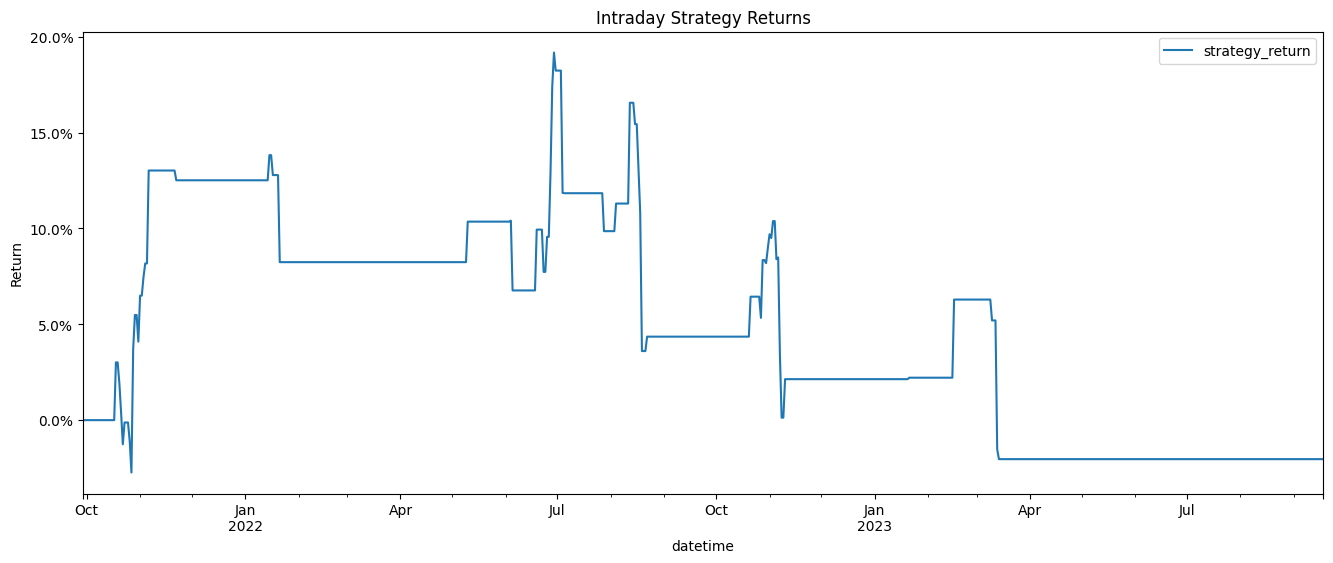

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from arch import arch_model
import pandas as pd
import pandas_ta
import numpy as np
import os

data_folder = '.'

daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv')).dropna(axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')

daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()
# daily_df 

intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))
intraday_5min_df = intraday_5min_df.loc[:, ~intraday_5min_df.columns.str.contains('^Unnamed')]
intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])
intraday_5min_df['date'] = intraday_5min_df['datetime'].dt.date
intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df['date'])
intraday_5min_df = intraday_5min_df.set_index('datetime')
# intraday_5min_df

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()
daily_df = daily_df['2020-01-01':].copy()

def predict_volatility(x):
    x_scaled = x * 100  # Rescale to improve numerical stability
    best_model = arch_model(y=x_scaled,
                            p=1,
                            q=3).fit(update_freq=5, disp='off')
    variance_forecast_scaled = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    variance_forecast = variance_forecast_scaled / (100**2)

    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x:predict_volatility(x))
# daily_df

daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']
daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()
daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std']*1.5)
                                          else (-1 if (x['prediction_premium']<x['premium_std']*-1.5) else np.nan),
                                         axis=1)
daily_df['signal_daily'] = daily_df['signal_daily'].shift()
# daily_df['signal_daily'].plot(kind='hist')
# plt.show()
    
final_df = intraday_5min_df.reset_index().merge(daily_df[['signal_daily']].reset_index(),
                                                left_on='date',
                                                right_on='Date').set_index('datetime')
final_df = final_df.drop(['date', 'Date'], axis=1)
final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)
final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]
final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]
final_df['signal_intraday'] = final_df.apply(lambda x:1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)
# final_df

final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                             else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                             axis=1)
final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign'].transform(lambda x:x.ffill())
final_df['return'] = final_df['close'].pct_change()
final_df['forward_return'] = final_df['return'].shift(-1)
final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']
# final_df[final_df['return_sign']==1]

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))[['strategy_return']].sum()
# daily_return_df
strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)
strategy_cumulative_return.plot(figsize=(16,6))
plt.title('Intraday Strategy Returns')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()